In [201]:
import numpy as np
from scipy.stats import multivariate_normal
from statsmodels.tsa.arima_model import ARIMA
import scipy.stats as st
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [365]:
n = 100 #количество товаров
m = 1000 #число клиентов
clients = []

for client in range(m):
    #prices1 = st.bernoulli.rvs(0.5, size = n)
    prices2 = st.norm.rvs(1, 0.3, size = n)
    #clients.append(prices1 * prices2)
    clients.append(prices2)
    
def receive_R(p):
    R = 0
    f = np.zeros(n)
    for client in clients:
        aval_items = []
        for e, item in enumerate(client):
            if p[e] <= item:
                aval_items.append((p[e], item, e))
        if len(aval_items) != 0:
            aval_items = sorted(aval_items, key = lambda x: x[1])
            R += aval_items[-1][0]
            f[aval_items[-1][2]] += 1
    return (R, f)

In [366]:
mu_new = np.array([-2 for _ in range(n)]) #начальные параметры на распределение gamma
Sigma_new = np.diag(np.array([1 for _ in range(n)]))
mu_old = np.array([-2 for _ in range(n)])
Sigma_old = np.diag(np.array([1 for _ in range(n)]))
f = np.array([1 for _ in range(n)])
history = []
history.append(f)
R_result = []
p_old = np.array([60 for _ in range(n)])
lambd = 0.5
sigma = 5
T = 100
c1 = 70 #ограничения на выставляемые цены
c2 = 170

for t in tqdm(range(T)):
    
    #сэмплируем gamma распределения до тех пор, пока все компоненты не будут отрицательны
    gamma = multivariate_normal.rvs(mean=mu_new, cov=Sigma_new)
    while sum(gamma < 0) != n:
        gamma = multivariate_normal.rvs(mean=mu_new, cov=Sigma_new)
    print('gamma: {}'.format(gamma))


    #ищем оптимальные цены
    p_new = []
    for i in range(n):
        opt = (gamma[i] - 1) * p_old[i] / (2 * gamma[i])
        if opt < c1:
            p_new.append(c1)
        elif opt > c2:
            p_new.append(c2)
        else:
            p_new.append(opt)
    

    #применяем цены и получаем выигрыш 
    print('p_new: {}'.format(p_new))
    R, f = receive_R(p_new)
    print('R: {}'.format(R))
    print('f: {}'.format(f))
    R_result.append(R)
    
    f = f + 0.5

    #меняем параметры распределения для gamma
    theta = []
    R_mean = 0
    for i in range(n):
        theta.append((p_new[i] ** 2) * f[i] / p_old[i] - p_new[i] * f[i])
        R_mean += p_new[i] * f[i]

    theta = np.array(theta)
    M = np.outer(theta, theta.transpose()) / (sigma ** 2) + lambd * np.diag(np.ones(n)) 
    Sigma_new = np.linalg.inv(np.linalg.inv(Sigma_old) + M)
    mu_new = Sigma_new @ (np.linalg.inv(Sigma_old) @ mu_old + ((R - R_mean) / sigma ** 2) * theta)
    Rev = []
    for i in range(n):
        Rev.append((p_new[i] ** 2) * f[i] * gamma[i] / p_old[i] - p_new[i] * f[i] * gamma[i] + p_new[i] * f[i])
    print('Rev: {}'.format(Rev))
    print('Sigma: {}'.format(Sigma_new))
    print('Mu: {}'.format(mu_new))
    
    p_old = p_new.copy()
    mu_old = mu_new.copy()
    Sigma_old = Sigma_new.copy()

gamma: [-2.65337008 -3.61777158]
p_new: [70, 70]
R: 210
f: [0. 3.]
Rev: [19.52200788326779, 97.27432719014053]
Sigma: [[ 0.65362087 -0.09132055]
 [-0.09132055  0.02742279]]
Mu: [-1.35942492 -1.51597444]
gamma: [-2.0764827  -1.51879947]
p_new: [70, 70]
R: 210
f: [0. 3.]
Rev: [35.0, 245.0]
Sigma: [[ 0.49028549 -0.06800159]
 [-0.06800159  0.0239889 ]]
Mu: [-1.0777161  -1.54401269]
gamma: [-1.07230438 -1.54704646]
p_new: [70, 70]
R: 210
f: [0. 3.]
Rev: [35.0, 245.0]
Sigma: [[ 0.39228346 -0.05401575]
 [-0.05401575  0.02188976]]
Mu: [-0.9080315  -1.55622047]
gamma: [-0.71774491 -1.5064435 ]
p_new: [83.76384290162667, 70]
R: 210
f: [0. 3.]
Rev: [35.971228681683435, 245.00000000000006]
Sigma: [[ 0.1732725  -0.02368771]
 [-0.02368771  0.01758664]]
Mu: [-4.80914874 -1.01174252]
gamma: [-5.13968594 -1.1178541 ]
p_new: [70, 70]
R: 210
f: [0. 3.]
Rev: [64.55886405554546, 244.99999999999994]
Sigma: [[ 0.13151766 -0.01785143]
 [-0.01785143  0.01666919]]
Mu: [-1.54730842 -1.44727868]
gamma: [-1.304063

Mu: [-0.91676493 -1.01975823]
gamma: [-0.84041473 -0.94430734]
p_new: [80.09660245458866, 102.5632192801717]
R: 307.6896578405151
f: [0. 3.]
Rev: [36.85274167084597, 348.9752349050776]
Sigma: [[ 0.01238318 -0.00035434]
 [-0.00035434  0.00182593]]
Mu: [-1.04482487 -1.07440713]
gamma: [-1.14269571 -1.05221153]
p_new: [75.09551537417147, 100.01858709871001]
R: 300.0557612961301
f: [0. 3.]
Rev: [40.22670964430217, 359.2037709765912]
Sigma: [[ 0.0122805  -0.00036722]
 [-0.00036722  0.00181525]]
Mu: [-0.93687972 -1.01439866]
gamma: [-0.98107005 -1.01713541]
p_new: [75.82000713175138, 99.17609378574438]
R: 297.52828135723314
f: [0. 3.]
Rev: [37.551186335221246, 350.0903186660554]
Sigma: [[ 0.01220426 -0.00036344]
 [-0.00036344  0.00181235]]
Mu: [-0.95126848 -0.99406796]
gamma: [-1.06322904 -1.0237261 ]
p_new: [73.56554172967836, 98.02683056661303]
R: 294.08049169983906
f: [0. 3.]
Rev: [37.945640485908946, 347.1640464261552]
Sigma: [[ 0.01212459 -0.00036413]
 [-0.00036413  0.0018088 ]]
Mu: [-0

gamma: [-1.12626871 -1.02119869]
p_new: [106.26837529141746, 120.20666151983289]
R: 240.41332303966578
f: [0. 2.]
Rev: [56.48878033454811, 303.7019335827707]
Sigma: [[ 6.29107207e-03 -5.16029157e-05]
 [-5.16029157e-05  1.16702949e-03]]
Mu: [-0.9861579  -0.99379816]
gamma: [-1.09682068 -0.967829  ]
p_new: [101.57801139411484, 122.20451902847755]
R: 122.20451902847755
f: [0. 1.]
Rev: [53.24771869975689, 180.35819708954608]
Sigma: [[ 6.26327532e-03 -4.93287172e-05]
 [-4.93287172e-05  1.16581015e-03]]
Mu: [-0.92004619 -1.0095148 ]
gamma: [-1.02660769 -1.00233729]
p_new: [100.2616583803729, 122.06203827514713]
R: 122.06203827514713
f: [0. 1.]
Rev: [50.797761975338474, 183.30702830697257]
Sigma: [[ 6.24306639e-03 -4.91811523e-05]
 [-4.91811523e-05  1.16512790e-03]]
Mu: [-0.89908019 -1.0079784 ]
gamma: [-0.99646368 -0.99407509]
p_new: [100.43956626809491, 122.42579660750602]
R: 122.42579660750602
f: [0. 1.]
Rev: [50.13098647507547, 183.09467383837384]
Sigma: [[ 6.22362676e-03 -4.90129251e-05]

f: [0. 0.]
Rev: [56.37548382425686, 75.05118227128759]
Sigma: [[ 3.87924556e-03 -3.67773799e-05]
 [-3.67773799e-05  1.07184026e-03]]
Mu: [-0.96409931 -1.00975951]
gamma: [-1.00791268 -0.94917912]
p_new: [109.04411508208649, 154.0310833771709]
R: 0
f: [0. 0.]
Rev: [54.73776527256378, 75.05854293470901]
Sigma: [[ 3.87170248e-03 -3.66063652e-05]
 [-3.66063652e-05  1.07106898e-03]]
Mu: [-0.95756248 -1.02073038]
gamma: [-0.97532155 -0.97624708]
p_new: [110.42368045594283, 155.90493707544144]
R: 0
f: [0. 0.]
Rev: [54.5305689246199, 77.0266690640245]
Sigma: [[ 3.86393729e-03 -3.66215519e-05]
 [-3.66215519e-05  1.07045585e-03]]
Mu: [-0.96974816 -1.02540776]
gamma: [-0.94864845 -1.02235982]
p_new: [113.41236774265315, 154.20005486169362]
R: 0
f: [0. 0.]
Rev: [55.250208658976995, 77.9619987520622]
Sigma: [[ 3.85507062e-03 -3.63034570e-05]
 [-3.63034570e-05  1.06984585e-03]]
Mu: [-0.99958072 -1.01977476]
gamma: [-0.9744553  -1.02263752]
p_new: [114.89888284163152, 152.4933371981723]
R: 0
f: [0. 0

Rev: [61.10178309380763, 79.71893827718044]
Sigma: [[ 3.11541825e-03 -2.12594349e-05]
 [-2.12594349e-05  1.01252468e-03]]
Mu: [-0.96440454 -1.01009248]
gamma: [-1.00812966 -1.05800971]
p_new: [121.01132273148062, 159.95781896608727]
R: 0
f: [0. 0.]
Rev: [60.751606496764815, 82.29868600168169]
Sigma: [[ 3.11055236e-03 -2.12786950e-05]
 [-2.12786950e-05  1.01181612e-03]]
Mu: [-0.95884345 -0.99693743]
gamma: [-1.03298705 -0.99004029]
p_new: [119.07915616878174, 160.76239878444179]
R: 0
f: [0. 0.]
Rev: [60.52159548252198, 79.98091282769272]
Sigma: [[ 3.10537120e-03 -2.11840951e-05]
 [-2.11840951e-05  1.01129690e-03]]
Mu: [-0.94073441 -0.99885337]
gamma: [-1.04198011 -0.93905512]
p_new: [116.68037901631058, 165.97915561272166]
R: 0
f: [0. 0.]
Rev: [59.56475331703275, 80.46068304173495]
Sigma: [[ 3.10000921e-03 -2.07341252e-05]
 [-2.07341252e-05  1.01048390e-03]]
Mu: [-0.91860959 -1.01370598]
gamma: [-0.97170899 -0.97917197]
p_new: [118.37893607656711, 167.74443236840585]
R: 0
f: [0. 0.]
Rev

gamma: [-0.99780135 -0.96046312]
p_new: [133.55488379286527, 170]
R: 0
f: [0. 0.]
Rev: [66.7040316331966, 84.62432149848901]
Sigma: [[ 2.52528419e-03 -1.54807799e-05]
 [-1.54807799e-05  9.51105364e-04]]
Mu: [-0.98995199 -0.97681364]
gamma: [-0.92228036 -1.00443958]
p_new: [139.1821517247975, 169.62430363575487]
R: 0
f: [0. 0.]
Rev: [66.88677920491996, 85.00041698351431]
Sigma: [[ 2.51991216e-03 -1.53878273e-05]
 [-1.53878273e-05  9.50651162e-04]]
Mu: [-1.0335604  -0.97500209]
gamma: [-1.03504467 -0.92219163]
p_new: [136.8259284852559, 170]
R: 0
f: [0. 0.]
Rev: [69.61171912901561, 84.82638429227151]
Sigma: [[ 2.51640058e-03 -1.53382113e-05]
 [-1.53382113e-05  9.50197843e-04]]
Mu: [-1.01424711 -0.97576153]
gamma: [-0.98581857 -0.90375106]
p_new: [137.8100788665743, 170]
R: 0
f: [0. 0.]
Rev: [68.41645340776938, 85.0]
Sigma: [[ 2.51317625e-03 -1.53112843e-05]
 [-1.53112843e-05  9.49746500e-04]]
Mu: [-1.02062301 -0.97525937]
gamma: [-0.98197348 -0.96808682]
p_new: [139.07499875385386, 170]


Rev: [71.50002475348734, 85.0]
Sigma: [[ 2.21120034e-03 -1.26276522e-05]
 [-1.26276522e-05  9.13603396e-04]]
Mu: [-1.03237172 -0.93832743]
gamma: [-1.02235865 -0.99556683]
p_new: [144.5755376705447, 170]
R: 0
f: [0. 0.]
Rev: [73.09589712562651, 85.0]
Sigma: [[ 2.20863633e-03 -1.26072512e-05]
 [-1.26072512e-05  9.13186167e-04]]
Mu: [-1.0201967  -0.93796852]
gamma: [-0.99914727 -0.95065078]
p_new: [144.6372322986353, 170]
R: 0
f: [0. 0.]
Rev: [72.28778198750234, 85.0]
Sigma: [[ 2.20619972e-03 -1.25875956e-05]
 [-1.25875956e-05  9.12769324e-04]]
Mu: [-1.01950557 -0.93754442]
gamma: [-0.97067868 -0.95471113]
p_new: [146.82176270338562, 170]
R: 0
f: [0. 0.]
Rev: [72.33462947664006, 84.99999999999999]
Sigma: [[ 2.20352987e-03 -1.25666279e-05]
 [-1.25666279e-05  9.12352853e-04]]
Mu: [-1.03375886 -0.93703549]
gamma: [-1.046628   -0.97162959]
p_new: [143.55125699710334, 170]
R: 0
f: [0. 0.]
Rev: [73.44900563986636, 85.0]
Sigma: [[ 2.20060942e-03 -1.25442507e-05]
 [-1.25442507e-05  9.11936754e-0

 [-1.04005040e-05  8.69505872e-04]]
Mu: [-1.00294716 -0.89320889]
gamma: [-1.01002434 -0.89974198]
p_new: [151.11939220526983, 170]
R: 0
f: [0. 0.]
Rev: [75.93841415957483, 85.0]
Sigma: [[ 1.91169675e-03 -1.03859356e-05]
 [-1.03859356e-05  8.69127961e-04]]
Mu: [-0.99737873 -0.89285101]
gamma: [-1.03769457 -0.8650149 ]
p_new: [148.3746631083317, 170]
R: 0
f: [0. 0.]
Rev: [75.58556145053444, 85.0]
Sigma: [[ 1.90960629e-03 -1.03700722e-05]
 [-1.03700722e-05  8.68750372e-04]]
Mu: [-0.97990869 -0.89255808]
gamma: [-0.9928521  -0.89914088]
p_new: [148.90876453427057, 170]
R: 0
f: [0. 0.]
Rev: [74.18828598023148, 85.0]
Sigma: [[ 1.90777422e-03 -1.03556253e-05]
 [-1.03556253e-05  8.68373118e-04]]
Mu: [-0.98223442 -0.89215794]
gamma: [-1.00206257 -0.90590562]
p_new: [148.75551312966425, 170]
R: 0
f: [0. 0.]
Rev: [74.45446129013513, 84.99999999999999]
Sigma: [[ 1.90595524e-03 -1.03412619e-05]
 [-1.03412619e-05  8.67996193e-04]]
Mu: [-0.98037245 -0.89178087]
gamma: [-0.98716887 -0.90944227]
p_new

gamma: [-1.0541544  -0.86836442]
p_new: [154.24564804634588, 170]
R: 0
f: [0. 0.]
Rev: [79.21109397833287, 84.99999999999999]
Sigma: [[ 1.70182175e-03 -8.87177403e-06]
 [-8.87177403e-06  8.33968009e-04]]
Mu: [-0.97575562 -0.85685219]
gamma: [-0.92311723 -0.87965168]
p_new: [160.66890164344346, 170]
R: 0
f: [0. 0.]
Rev: [77.24628340016534, 85.0]
Sigma: [[ 1.69908152e-03 -8.85379724e-06]
 [-8.85379724e-06  8.33620328e-04]]
Mu: [-1.01177909 -0.85630735]
gamma: [-0.99705991 -0.88585887]
p_new: [160.90578838487525, 170]
R: 0
f: [0. 0.]
Rev: [80.33462493862844, 85.0]
Sigma: [[ 1.69763765e-03 -8.84258783e-06]
 [-8.84258783e-06  8.33272972e-04]]
Mu: [-1.01225579 -0.85594812]
gamma: [-1.00021477 -0.88774565]
p_new: [160.88851321560782, 170]
R: 0
f: [0. 0.]
Rev: [80.45289511998526, 84.99999999999999]
Sigma: [[ 1.69619784e-03 -8.83140891e-06]
 [-8.83140891e-06  8.32925906e-04]]
Mu: [-1.01130412 -0.85559662]
gamma: [-0.96162933 -0.85084403]
p_new: [164.09837808549517, 170]
R: 0
f: [0. 0.]
Rev: [80

Rev: [83.49142547975245, 85.0]
Sigma: [[ 1.53553195e-03 -7.66912675e-06]
 [-7.66912675e-06  7.98981612e-04]]
Mu: [-0.9867276  -0.82085714]
gamma: [-0.95081235 -0.8419961 ]
p_new: [170, 170]
R: 0
f: [0. 0.]
Rev: [83.40259890604652, 84.99999999999999]
Sigma: [[ 1.53408815e-03 -7.65885625e-06]
 [-7.65885625e-06  7.98662517e-04]]
Mu: [-1.0033288  -0.82044648]
gamma: [-1.04097367 -0.85515704]
p_new: [166.65432266714134, 170]
R: 0
f: [0. 0.]
Rev: [85.03427117037403, 85.0]
Sigma: [[ 1.53265957e-03 -7.64866995e-06]
 [-7.64866995e-06  7.98343678e-04]]
Mu: [-0.98547446 -0.8202081 ]
gamma: [-0.99496421 -0.82243676]
p_new: [167.0760644214727, 170]
R: 0
f: [0. 0.]
Rev: [83.32769228412879, 85.0]
Sigma: [[ 1.53148172e-03 -7.63974254e-06]
 [-7.63974254e-06  7.98025100e-04]]
Mu: [-0.98690293 -0.81987371]
gamma: [-0.97887977 -0.82675472]
p_new: [168.8784744487861, 170]
R: 0
f: [0. 0.]
Rev: [83.54754904068639, 85.0]
Sigma: [[ 1.53023215e-03 -7.63046458e-06]
 [-7.63046458e-06  7.97706774e-04]]
Mu: [-0.995

gamma: [-0.89754798 -0.7936845 ]
p_new: [170, 170]
R: 0
f: [0. 0.]
Rev: [85.0, 85.00000000000001]
Sigma: [[ 1.42633936e-03 -6.86595182e-06]
 [-6.86595182e-06  7.70061531e-04]]
Mu: [-0.94300107 -0.7913597 ]
gamma: [-0.90788411 -0.79272225]
p_new: [170, 170]
R: 0
f: [0. 0.]
Rev: [85.0, 85.0]
Sigma: [[ 1.42532284e-03 -6.85841802e-06]
 [-6.85841802e-06  7.69765125e-04]]
Mu: [-0.94233175 -0.79105836]



In [367]:
mu_new

array([-0.94233175, -0.79105836])

Text(0, 0.5, 'R')

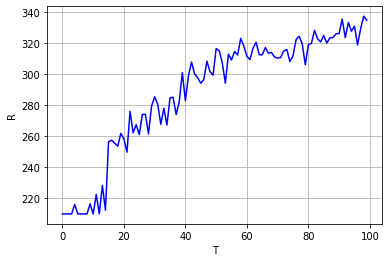

In [381]:
plt.plot(R_result, color='blue')
plt.grid()
plt.xlabel('T')
plt.ylabel('R')